In [161]:
import numpy as np
import pandas as pd
import email
from bs4 import BeautifulSoup
import cgi

from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


import matplotlib.pyplot as plt
%matplotlib inline

# Data pre-processing

## read trec05p/full/index into a dataframe

In [2]:
index_dir='./trec05p/full'
filename='/index'
f=open(index_dir+filename,'r')
lines=f.readlines()

In [3]:
email_id=list()
label=list()
path=list()
for line in lines:
    if line.startswith('s'):
        label.append(line[:4])
        path.append(line[7:-1])
    else:
        label.append(line[:3])
        path.append(line[6:-1])
    email_id.append(line[-8:-1])

In [4]:
label=pd.Series(label)
path=pd.Series(path)
email_id=pd.Series(email_id)
index=pd.DataFrame({'label':label,'path':path})
index.head()

,label,path
0,ham,/data/000/000
1,ham,/data/000/001
2,ham,/data/000/002
3,ham,/data/000/003
4,ham,/data/000/004


In [5]:
index.shape

(92189, 2)

## create dataframe (datatable doesn't work well for windows) for each email

In [5]:
email_dir='./trec05p'

In [21]:
parts=list()
attachments=list()
html=list()
subject=list()
body=list()
links=list()
drop_index=list()
receiver=list()

In [24]:
for i in range(len(index)):
    try:
        f=open(email_dir+index['path'][i],'rb')
    except:
    # drop files do not exist
        drop_index.append(i)
        continue
    b = email.message_from_binary_file(f)
    try:
        receiver_=b['to'].count('<')
    except:
        drop_index.append(i)
        continue

    body_ = ""
    attachments_=0
    html_=0 
    links_=0

    if b.is_multipart():
        parts_=0
        for part in b.walk():
            parts_+=1
            if part.get_content_type()=='text/html':
                html_=1
                body_= BeautifulSoup(part.get_payload(),'html.parser')
                links_=len(body_.find_all("a"))

            if part.get('Content-Disposition'):
                _,params=cgi.parse_header(part.get('Content-Disposition'))
                attachments_=len(params)

            if part.get_content_type() == 'text/plain':
                body_ = part.get_payload()  

            if part.get('Subject'):
                subject_=part.get('Subject')
    # not multipart 
    else:
        parts_=False
        body_ = b.get_payload()
        subject_=b.get('Subject')

    parts.append(parts_)
    attachments.append(attachments_)
    html.append(html_) 
    subject.append(subject_)
    body.append(body_)
    links.append(links_)
    receiver.append(receiver_)

In [35]:
email_id=email_id[~email_id.index.isin(drop_index)]
label=label[~label.index.isin(drop_index)]

In [36]:
data_all=pd.DataFrame({'email_id':email_id, 'parts':parts, 'attachments':attachments, 'html':html,'subject':subject,'body':body,'links':links,'receiver':receiver,'spam':label})
data_all.head()          

,email_id,parts,attachments,html,subject,body,links,receiver,spam
0,000/000,False,0,0,"FW: June 29 -- BNA, Inc. Daily Labor Report",User ID: enrondlr\nPW: bnaweb22\n\n\n ...,0,10,ham
1,000/001,False,0,0,NGX failover plan.,"\nHi Chris, \n\nTonight we are rolling out a ...",0,1,ham
2,000/002,False,0,0,RE: Intranet Site,Rika r these new?\n\n -----Original Message---...,0,1,ham
3,000/003,False,0,0,FW: ENA Upstream Company information,"John/Gerald,\n\nWe are currently trading under...",0,2,ham
4,000/004,False,0,0,New Master Physical,Gerald and Stacy -\n\nAttached is a worksheet ...,0,2,ham


In [37]:
data_all.shape

(89860, 9)

1.3 save dataframe into a csv file

In [38]:
data_all.to_csv('./emails_05.csv',index=False,header=True)

# Train/Test Split

In [2]:
filename='./emails_05.csv'
data=pd.read_csv(filename)
data.head()

,email_id,parts,attachments,html,subject,body,links,receiver,spam
0,000/000,False,0,0,"FW: June 29 -- BNA, Inc. Daily Labor Report",User ID: enrondlr\nPW: bnaweb22\n\n\n ...,0,10,ham
1,000/001,False,0,0,NGX failover plan.,"\nHi Chris, \n\nTonight we are rolling out a ...",0,1,ham
2,000/002,False,0,0,RE: Intranet Site,Rika r these new?\n\n -----Original Message---...,0,1,ham
3,000/003,False,0,0,FW: ENA Upstream Company information,"John/Gerald,\n\nWe are currently trading under...",0,2,ham
4,000/004,False,0,0,New Master Physical,Gerald and Stacy -\n\nAttached is a worksheet ...,0,2,ham


In [171]:
x_train, x_test, y_train, y_test=train_test_split(data.iloc[:,:-1],data.iloc[:,-1], test_size=0.15)
y_train=y_train=='spam'
y_test=y_test=='spam'

In [172]:
len(x_train),len(x_test)

(76381, 13479)

# Naive Bayes Spam Detection

## Structural Information Model

In [200]:
multipart=x_train['parts'].values
multipart[multipart=='False']=1
multipart[multipart!=1]=0

In [201]:
html=x_train['html'].values

In [202]:
links=x_train['links'].values
links[links==0]=0
links[links!=0]=1

In [203]:
attachments=x_train['attachments'].values
attachments[attachments==0]=0
attachments[attachments!=0]=1
train_features=np.c_[multipart,html,links,attachments]
train_features.shape

(76381, 4)

In [204]:
model1=BernoulliNB()
Y=y_train.values
model1.fit(train_features,Y)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [205]:
K=5
kf=KFold(K,shuffle=True)
folds=list(kf.split(train_features))

In [208]:
def auc_metric(model,X,Y):
    Y_score=model.predict_proba(X)[:,1]
    return roc_auc_score(Y,Y_score)
def model_cross_validation(model,X,y,folds,metric):
    kfolds=len(folds)
    train_performance=np.empty(kfolds)
    validation_performance=np.empty(kfolds)
    for idx in range(kfolds):
        train,validation=folds[idx]
        X_train=X[train]
        y_train=y[train]
        model.fit(X_train,y_train)
        train_accuracy=metric(model,X_train,y_train)
        X_validation=X[validation]
        y_validation=y[validation]
        validation_accuracy=metric(model,X_validation,y_validation)
        train_performance[idx]=train_accuracy
        validation_performance[idx]=validation_accuracy
    return train_performance,validation_performance

In [209]:
train_acc,val_acc=model_cross_validation(model1,train_features,Y,folds,auc_metric)
val_acc.mean()

0.7072130592192222

In [210]:
aucs=list()
aucs.append(val_acc.mean())

## Subject Model

In [211]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(x_train.subject.apply(lambda x: np.str_(x)))
X_train_counts.shape

(76381, 28634)

In [212]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(76381, 28634)

In [213]:
model2= MultinomialNB()
model2.fit(X_train_tfidf,y_train.values)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [214]:
K=5
kf=KFold(K,shuffle=True)
folds=list(kf.split(X_train_tfidf))
train_acc,val_acc=model_cross_validation(model2,X_train_tfidf,y_train.values,folds,auc_metric)
val_acc.mean()

0.9747505886951418

In [215]:
aucs.append(val_acc.mean())

## Message Body Model

In [216]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(x_train.body.apply(lambda x: np.str_(x)))
X_train_counts.shape

(76381, 444408)

In [217]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(76381, 444408)

In [218]:
model3= MultinomialNB()
model3.fit(X_train_tfidf,y_train.values)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [219]:
K=5
kf=KFold(K,shuffle=True)
folds=list(kf.split(X_train_tfidf))
train_acc,val_acc=model_cross_validation(model3,X_train_tfidf,y_train.values,folds,auc_metric)
val_acc.mean()

0.9943551151451206

In [220]:
aucs.append(val_acc.mean())

## Bulk-Receiver Model

In [257]:
X=x_train.receiver.values
X.shape

(76381,)

In [222]:
X=X.reshape(-1, 1)
model4= GaussianNB()
model4.fit(X,y_train.values)

GaussianNB(priors=None, var_smoothing=1e-09)

In [223]:
K=5
kf=KFold(K,shuffle=True)
folds=list(kf.split(X))
train_acc,val_acc=model_cross_validation(model4,X,y_train.values,folds,auc_metric)
val_acc.mean()

0.7855888617773085

In [224]:
aucs.append(val_acc.mean())

## Combined Model

In [266]:
multipart=x_train['parts'].values
multipart[multipart=='False']=1
multipart[multipart!=1]=0
html=x_train['html'].values
links=x_train['links'].values
links[links==0]=0
links[links!=0]=1
attachments=x_train['attachments'].values
attachments[attachments==0]=0
attachments[attachments!=0]=1
train_features=np.c_[multipart,html,links,attachments]
train_features.shape

(76381, 4)

In [267]:
model5_1=BernoulliNB(fit_prior=False)
model5_1.fit(train_features,y_train.values)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=False)

In [268]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(x_train.subject.apply(lambda x: np.str_(x)))
tfidf_transformer = TfidfTransformer()
X_train_tfidf_1 = tfidf_transformer.fit_transform(X_train_counts)
model5_2=MultinomialNB(fit_prior=False)
model5_2.fit(X_train_tfidf_1,y_train.values)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

In [269]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(x_train.body.apply(lambda x: np.str_(x)))
tfidf_transformer = TfidfTransformer()
X_train_tfidf_2 = tfidf_transformer.fit_transform(X_train_counts)
model5_3=MultinomialNB(fit_prior=True)
model5_3.fit(X_train_tfidf_2,y_train.values)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [238]:
def proba(model,X):
    return model.predict_proba(X)
def predict(model1,X1,model2,X2,model3,X3,proba):
    results=np.multiply(proba(model1,X1),proba(model2,X2),proba(model3,X3))
    pred=[]
    for i in results:
        if np.argmax(i)==0:
            pred.append(False)
        else:
            pred.append(True)
    return pred

In [239]:
y_pred=predict(model5_1,train_features,model5_2,X_train_tfidf_1,model5_3,X_train_tfidf_2,proba)

In [240]:
aucs.append(np.sum(y_pred==y_train)/len(y_train))
np.sum(y_pred==y_train)/len(y_train)

0.9217475550202275

# Analyze Best Model

## Best Model Selection

In [241]:
best_idx=np.argmax(aucs)
print("best model number",best_idx+1)
print("best AUC",aucs[best_idx])

best model number 3
best AUC 0.9943551151451206


In [242]:
print('best model is Message Body Model')

best model is Message Body Model


## Analysis of Best Model

In [271]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(x_train.body.apply(lambda x: np.str_(x)))
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
best_model=MultinomialNB()
best_model.fit(X_train_tfidf,y_train.values)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [272]:
X_test_counts = count_vect.transform(x_test.body.apply(lambda x: np.str_(x)))
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [244]:
Y_pred=best_model.predict(X_test_tfidf)
Y_test=y_test.values
test_acc=np.mean(Y_pred==Y_test)
print("Test accuracy",test_acc)
y_score=best_model.predict_proba(X_test_tfidf)[:,1]
auc=roc_auc_score(Y_test,y_score)
print("AUC",auc)
fpr,tpr,thresholds=roc_curve(Y_test,y_score)

Test accuracy 0.9577861859188367
AUC 0.9949422777643618


In [270]:
multipart=x_test['parts'].values
multipart[multipart=='False']=1
multipart[multipart!=1]=0
html=x_test['html'].values
links=x_test['links'].values
links[links==0]=0
links[links!=0]=1
attachments=x_test['attachments'].values
attachments[attachments==0]=0
attachments[attachments!=0]=1
test_features=np.c_[multipart,html,links,attachments]
Y_test=y_test.values
y_score=model1.predict_proba(test_features)[:,1]
fpr1,tpr1,thresholds1=roc_curve(Y_test,y_score)

In [294]:
count_vect2 = CountVectorizer()
X_train_counts = count_vect2.fit_transform(x_train.subject.apply(lambda x: np.str_(x)))
tfidf_transformer2 = TfidfTransformer()
X_train_tfidf = tfidf_transformer2.fit_transform(X_train_counts)
model2=MultinomialNB()
model2.fit(X_train_tfidf,y_train.values)
X_test_counts = count_vect2.transform(x_test.subject.apply(lambda x: np.str_(x)))
X_test_tfidf_1 = tfidf_transformer2.transform(X_test_counts)
Y_test=y_test.values
y_score=model2.predict_proba(X_test_tfidf_1)[:,1]
fpr2,tpr2,thresholds2=roc_curve(Y_test,y_score)

In [260]:
X=x_test.receiver.values
X=X.reshape(-1, 1)
Y_test=y_test.values
y_score=model4.predict_proba(X)[:,1]
fpr3,tpr3,thresholds3=roc_curve(Y_test,y_score)

In [273]:
def proba(model,X):
    return model.predict_proba(X)
def score(model1,X1,model2,X2,model3,X3,proba):
    results=np.multiply(proba(model1,X1),proba(model2,X2),proba(model3,X3))
    return results[:,1]
y_score=score(model5_1,test_features,model5_2,X_test_tfidf_1,model5_3,X_test_tfidf,proba)

In [274]:
fpr4,tpr4,thresholds4=roc_curve(Y_test,y_score)

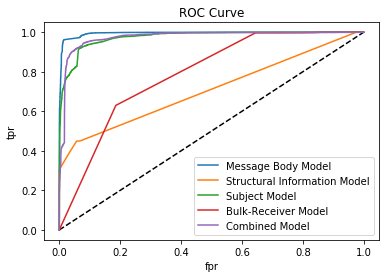

In [275]:
plt.plot([0,1],[0,1],"k--")
plt.plot(fpr,tpr,label="Message Body Model")
plt.plot(fpr1,tpr1,label="Structural Information Model")
plt.plot(fpr2,tpr2,label="Subject Model")
plt.plot(fpr3,tpr3,label="Bulk-Receiver Model")
plt.plot(fpr4,tpr4,label="Combined Model")
plt.title("ROC Curve")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(loc='best')
plt.show()

In [276]:
threshold_idx=np.argmin((fpr-.01)**2)+1
tpr_1=tpr[threshold_idx]
fpr_1=fpr[threshold_idx]

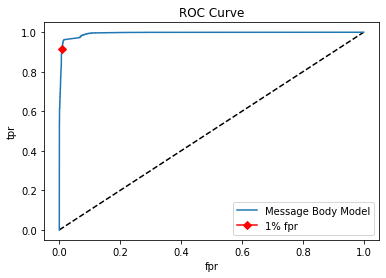

percentage 0.9160396039603961


In [282]:
plt.plot([0,1],[0,1],"k--")
plt.plot(fpr,tpr,label="Message Body Model")
plt.plot(fpr_1, tpr_1, marker='D', markersize=6, color="red",label="1% fpr")
plt.title("ROC Curve")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(loc='best')
plt.show()
print('percentage',tpr_1)

In [284]:
threshold_idx=np.argmin((fpr-.002)**2)+1
tpr_2=tpr[threshold_idx]
fpr_2=fpr[threshold_idx]

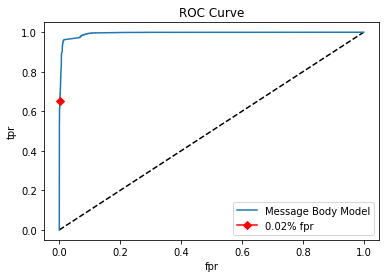

percentage 0.6501650165016502


In [285]:
pltplot([0,1],[0,1],"k--")
plt.plot(fpr,tpr,label="Message Body Model")
plt.plot(fpr_2, tpr_2, marker='D', markersize=6, color="red",label="0.02% fpr")
plt.title("ROC Curve")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(loc='best')
plt.show()
print('percentage',tpr_2)

# TREC 2006 Analysis

## TREC 2006 Data Pre-processing

In [39]:
index_dir='./trec06p/full'
filename='/index'
f=open(index_dir+filename,'r')
lines=f.readlines()

In [40]:
email_id=list()
label=list()
path=list()
for line in lines:
    if line.startswith('s'):
        label.append(line[:4])
        path.append(line[7:-1])
    else:
        label.append(line[:3])
        path.append(line[6:-1])
    email_id.append(line[-8:-1])

In [41]:
label=pd.Series(label)
path=pd.Series(path)
email_id=pd.Series(email_id)
index=pd.DataFrame({'label':label,'path':path})
index.head()

,label,path
0,ham,/data/000/000
1,spam,/data/000/001
2,spam,/data/000/002
3,ham,/data/000/003
4,spam,/data/000/004


In [42]:
.shape

(37822, 2)

In [43]:
email_dir='./trec06p'

In [44]:
parts=list()
attachments=list()
html=list()
subject=list()
body=list()
links=list()
drop_index=list()
receiver=list()

In [45]:
for i in range(len(index)):
    try:
        f=open(email_dir+index['path'][i],'rb')
    except:
    # drop files do not exist
        drop_index.append(i)
        continue
    b = email.message_from_binary_file(f)
    try:
        receiver_=b['to'].count('<')
    except:
        drop_index.append(i)
        continue

    body_ = ""
    attachments_=0
    html_=0 
    links_=0

    if b.is_multipart():
        parts_=0
        for part in b.walk():
            parts_+=1
            if part.get_content_type()=='text/html':
                html_=1
                body_= BeautifulSoup(part.get_payload(),'html.parser')
                links_=len(body_.find_all("a"))

            if part.get('Content-Disposition'):
                _,params=cgi.parse_header(part.get('Co ntent-Disposition'))
                attachments_=len(params)

            if part.get_content_type() == 'text/plain':
                body_ = part.get_payload()  

            if part.get('Subject'):
                subject_=part.get('Subject')
    # not multipart 
    else:
        parts_=False
        body_ = b.get_payload()
        subject_=b.get('Subject')

    parts.append(parts_)
    attachments.append(attachments_)
    html.append(html_) 
    subject.append(subject_)
    body.append(body_)
    links.append(links_)
    receiver.append(receiver_)

In [ ]:
email_id=email_id[~email_id.index.isin(drop_index)]
label=label[~label.index.isin(drop_index)]
data_all=pd.DataFrame({'email_id':email_id, 'parts':parts, 'attachments':attachments, 'html':html,'subject':subject,'body':body,'links':links,'receiver':receiver,'spam':label})
data_all.head()   

In [47]:
data_all.shape

(37018, 9)

In [48]:
data_all.to_csv('./emails_06.csv',index=False,header=True)

## Performance Analysis 

In [296]:
filename='./emails_06.csv'
data=pd.read_csv(filename)
data.head()

,email_id,parts,attachments,html,subject,body,links,receiver,spam
0,000/001,2,0,0,re[12]:,\n ...,0,1,spam
1,000/002,False,0,0,Take a moment to explore this.,Academic Qualifications available from prestig...,0,1,spam
2,000/003,False,0,0,Greetings,Greetings all. This is to verify your subscri...,0,1,ham
3,000/004,3,0,1,LOANS @ 3.17% (27 term),"<html>\n<head>\n<meta content=""en-us"" http-equ...",1,0,spam
4,000/005,False,0,0,who wants to start?,"It's quiet. Too quiet. Well, how about a str...",0,1,ham


In [297]:
x_test,y_test=data.iloc[:,:-1],data.iloc[:,-1]
y_test=y_test=='spam'

In [298]:
X_test_counts = count_vect.transform(x_test.body.apply(lambda x: np.str_(x)))
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
Y_pred=best_model.predict(X_test_tfidf)
Y_test=y_test.values
test_acc=np.mean(Y_pred==Y_test)
print("Test accuracy",test_acc)
y_score=best_model.predict_proba(X_test_tfidf)[:,1]
auc=roc_auc_score(Y_test,y_score)
print("AUC",auc)
fpr,tpr,thresholds=roc_curve(Y_test,y_score)

Test accuracy 0.9075854989464585
AUC 0.9461201880232942


In [301]:
multipart=x_test['parts'].values
multipart[multipart=='False']=1
multipart[multipart!=1]=0
html=x_test['html'].values
links=x_test['links'].values
links[links==0]=0
links[links!=0]=1
attachments=x_test['attachments'].values
attachments[attachments==0]=0
attachments[attachments!=0]=1
test_features=np.c_[multipart,html,links,attachments]
Y_test=y_test.values
y_score=model1.predict_proba(test_features)[:,1]
fpr1,tpr1,thresholds1=roc_curve(Y_test,y_score)
Y_pred=model1.predict(test_features)
test_acc=np.mean(Y_pred==Y_test)
print("Test accuracy",test_acc)
auc=roc_auc_score(Y_test,y_score)
print("AUC",auc)

Test accuracy 0.6033281106488735
AUC 0.6923101797468495


In [302]:
X_test_counts = count_vect2.transform(x_test.subject.apply(lambda x: np.str_(x)))
X_test_tfidf_1 = tfidf_transformer2.transform(X_test_counts)
Y_test=y_test.values
y_score=model2.predict_proba(X_test_tfidf_1)[:,1]
fpr2,tpr2,thresholds2=roc_curve(Y_test,y_score)
Y_pred=model2.predict(X_test_tfidf_1)
test_acc=np.mean(Y_pred==Y_test)
print("Test accuracy",test_acc)
auc=roc_auc_score(Y_test,y_score)
print("AUC",auc)

Test accuracy 0.7812415581608947
AUC 0.8367378561762419


In [303]:
X=x_test.receiver.values
X=X.reshape(-1, 1)
Y_test=y_test.values
y_score=model4.predict_proba(X)[:,1]
fpr3,tpr3,thresholds3=roc_curve(Y_test,y_score)
Y_pred=model4.predict(X)
test_acc=np.mean(Y_pred==Y_test)
print("Test accuracy",test_acc)
auc=roc_auc_score(Y_test,y_score)
print("AUC",auc)

Test accuracy 0.6535199092333459
AUC 0.5305516725314465


In [305]:
Y_pred=predict(model5_1,test_features,model5_2,X_test_tfidf_1,model5_3,X_test_tfidf,proba)
y_score=score(model5_1,test_features,model5_2,X_test_tfidf_1,model5_3,X_test_tfidf,proba)
fpr4,tpr4,thresholds4=roc_curve(Y_test,y_score)
test_acc=np.mean(Y_pred==Y_test)
print("Test accuracy",test_acc)
auc=roc_auc_score(Y_test,y_score)
print("AUC",auc)

Test accuracy 0.7966394726889622
AUC 0.8806254605325815


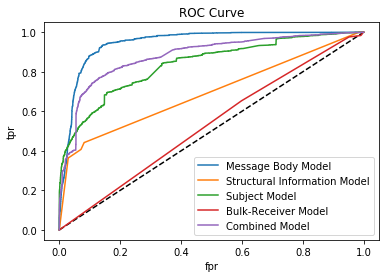

In [306]:
plt.plot([0,1],[0,1],"k--")
plt.plot(fpr,tpr,label="Message Body Model")
plt.plot(fpr1,tpr1,label="Structural Information Model")
plt.plot(fpr2,tpr2,label="Subject Model")
plt.plot(fpr3,tpr3,label="Bulk-Receiver Model")
plt.plot(fpr4,tpr4,label="Combined Model")
plt.title("ROC Curve")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(loc='best')
plt.show()

## Discussion

The performances on the original test set and the TREC 2006 data are basically the same. The best classifier is based on Message Body Model.

Anti-spam systems provide methods for the user to notify the spam software that some messages have been miss-classiﬁed because it will help the software to improve the model and accuracy as well.